# TimeSeries.decode(start_bit=n, n_bits=nb)

This function is useful when you have stored quality/status signals, typically encoded as integer-bit-fields
from remote sensors into a time-series.

The remote-sensor give two values, one representing the observed value, e.g. temperature, then another bit-encoded value (integer-type), that has an encoded information about more data about the temperature. E.g. the sensor-battery is below normal range.

This function converts the converted bit-sections of each ts-value into its corresponding decoded value.




In [1]:
%pylab inline
import os
import datetime as dt
from os import path
import sys
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
# try to auto-configure the path, -will work in all cases where doc and data
# are checked out at same level
shyft_data_path = path.abspath("../../../shyft-data")
if path.exists(shyft_data_path) and 'SHYFT_DATA' not in os.environ:
    os.environ['SHYFT_DATA']=shyft_data_path

In [3]:
from shyft.api import TimeSeries,Calendar,TimeAxis,POINT_AVERAGE_VALUE,DoubleVector,deltahours

In [13]:
utc = Calendar()
t0 = utc.time(2018, 1, 1)
delta_t = deltahours(1)
stat_v = DoubleVector()
temp_v = DoubleVector()
temp_v[:] = [-1.0, 2.3,4.2, 8.7,10.0, 11.2, 8.2]   # temperature signal values, as read from sensor
stat_v[:] = [1.0, 1.0, 3.0, 5.0, 15.0, 14.0, 13.0]  # these are bit-encoded values, as read from sensor
stat_ts = TimeSeries(TimeAxis(t0, delta_t, len(stat_v)), stat_v, POINT_AVERAGE_VALUE)
temp_ts = TimeSeries(TimeAxis(t0, delta_t, len(temp_v)), temp_v, POINT_AVERAGE_VALUE)

# decode the encoded stat_ts values, supplying the bits
temp_ok = stat_ts.decode(start_bit=0, n_bits=1)  # bit 0, 1 bits long, if 0, then value is invalid, 1 means ok value
batt_lvl = stat_ts.decode(start_bit=1, n_bits=3)  # bit 1, 3 bits long, battery-level, 0..7, 0=flat 7=100%


Text(0,0.5,'temperature [degC]')

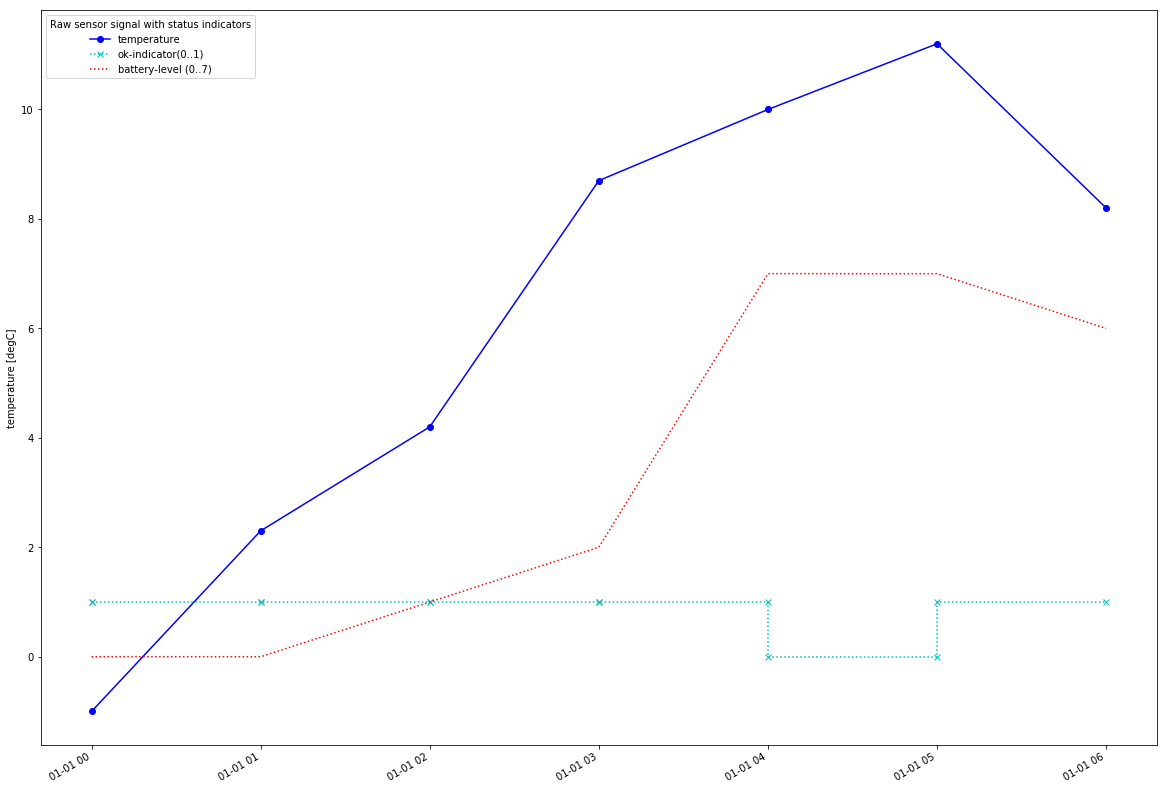

In [15]:
#utilize that we know that all the percentile time-series share a common time-axis
ts_timestamps = [dt.datetime.utcfromtimestamp(p.start) for p in stat_ts.time_axis] 

# Then we can make another plot of the percentile data for the sub-catchments
fig, ax = plt.subplots(figsize=(20,15))
ax.plot(ts_timestamps, temp_ts.values, label = "temperature",marker='o', color='b')
ax.step(ts_timestamps, temp_ok.values, label = "ok-indicator(0..1)",marker='x',color='c',linestyle='dotted')
ax.plot(ts_timestamps, batt_lvl.values, label = "battery-level (0..7)",color='r',linestyle='dotted')

# also plot catchment discharge along with the statistics
# notice that we use .average(ta_statistics) to properly align true-average values to time-axis
#ax.plot(ts_timestamps, discharge_ts[0].average(ta_statistics).values, 
#        label = "CID {}".format(model.catchment_ids[0]),
#        linewidth=2.0, alpha=0.7, color='b')

fig.autofmt_xdate()
ax.legend(title="Raw sensor signal with status indicators")
ax.set_ylabel("temperature [degC]")